In [1]:
import numpy as np
from scipy.optimize import minimize
from consav.linear_interp import interp_1d, interp_2d, interp_3d, interp_4d
import matplotlib.pyplot as plt
from optimizer import optimizer

# from scipy.optimize import minimize_scalar

# def optimizer(obj, a, b, args=(), tol=1e-6):
#     res = minimize_scalar(lambda x: obj(x, *args),
#                           bounds=(a, b),
#                           method="bounded",
#                           options={"xatol": tol})
#     return res.x


In [2]:
T = 4

X = 0.8
psi = 0.9
beta = 0.96

h_max = 1

N_a = 200
N_a_max = 4
a_grid = np.arange(0, N_a + 1) / (N_a / N_a_max)
m_grid = np.arange(0, N_a + 1) / (N_a / (N_a_max + h_max + X))

shape = (T, N_a + 1)

sol_V_work = np.full(shape, np.nan)
sol_h_work = np.full(shape, np.nan)
sol_c_work = np.full(shape, np.nan)

sol_V_notwork = np.full(shape, np.nan)
sol_h_notwork = np.full(shape, np.nan)
sol_c_notwork = np.full(shape, np.nan)

c_given_m = np.full(shape, np.nan)

def scalar(x):
    return x[0] if np.ndim(x) > 0 else x

def value_function_last_period(h, a, t):
    h = scalar(h)
    a = scalar(a)

    c = h + a + B(h, t)

    if c <= 0:
        c = 0.0
    
    return - (np.log(c+1e-5) - (h**2)/2)


def value_function_inner(c, h, sol_V_work, sol_V_notwork, a, t):
    c = scalar(c)
    h = scalar(h)

    m = h + a + B(h, t)
    a_next = m - c

    sol_V_next = max(interp_1d(a_grid, sol_V_work[t+1, :], a_next), 
                     interp_1d(a_grid, sol_V_notwork[t+1, :], a_next))

    return - (np.log(c+1e-5) - (h**2)/2 + beta*sol_V_next)


def value_function_given_m(c, sol_V_work, sol_V_notwork, m, t):
    c = scalar(c)

    a_next = m - c

    sol_V_next = max(interp_1d(a_grid, sol_V_work[t+1, :], a_next), 
                     interp_1d(a_grid, sol_V_notwork[t+1, :], a_next))

    return - (np.log(c+1e-5) + beta*sol_V_next)


def value_function_outer(h, c_given_m, sol_V_work, sol_V_notwork, a, t):
    a = scalar(a)
    h = scalar(h)

    m = h + a + B(h, t)

    c_star = interp_1d(m_grid, c_given_m[t, :], m)

    v_star = value_function_inner(c_star, h, sol_V_work, sol_V_notwork, a, t)

    return v_star


def B(h, t):
    h = scalar(h)
    if t < 2:
        return 0.5 * X if h == 0.0 else 0.0
        
    else:
        return (1-psi*h)*X
    

for t in range(T - 1, -1, -1):
    
    for m_idx, m in enumerate(m_grid):
        if t != T-1:
            c_given_m[t, m_idx] = optimizer(
                        value_function_given_m,
                        a=1e-8,
                        b=(m + 1e-6),
                        args=(sol_V_work, sol_V_notwork, m, t)
            )

    for a_idx, a in enumerate(a_grid):
        
        if t == T-1:

            sol_h_work[t, a_idx] = optimizer(
                        value_function_last_period,
                        a=0.1,
                        b=1,
                        args=(a,t)
            )
            
            sol_V_work[t, a_idx] = - value_function_last_period(sol_h_work[t, a_idx], a, t)
            sol_c_work[t, a_idx] = sol_h_work[t, a_idx] + a + B(sol_h_work[t, a_idx], t)


            sol_h_notwork[t, a_idx] = 0.0
            sol_V_notwork[t, a_idx] = - value_function_last_period(sol_h_notwork[t, a_idx], a, t)
            sol_c_notwork[t, a_idx] = a + B(sol_h_notwork[t, a_idx], t) 


        else:

            sol_h_work[t, a_idx] = optimizer(value_function_outer,
                                    a=0.1,
                                    b=1,
                                    args=(c_given_m, sol_V_work, sol_V_notwork, a, t)
            )
            
            sol_V_work[t, a_idx] = - value_function_outer(sol_h_work[t, a_idx], c_given_m, sol_V_work, sol_V_notwork, a, t)
            m = sol_h_work[t, a_idx] + a + B(sol_h_work[t, a_idx], t)
            sol_c_work[t, a_idx] = interp_1d(m_grid, c_given_m[t, :], m)


            sol_h_notwork[t, a_idx] = 0.0
            sol_V_notwork[t, a_idx] = - value_function_outer(sol_h_notwork[t, a_idx], c_given_m, sol_V_work, sol_V_notwork, a, t)
            m = a + B(sol_h_notwork[t, a_idx], t)
            sol_c_notwork[t, a_idx] = interp_1d(m_grid, c_given_m[t, :], m)


In [9]:
m_grid

array([0.   , 0.029, 0.058, 0.087, 0.116, 0.145, 0.174, 0.203, 0.232,
       0.261, 0.29 , 0.319, 0.348, 0.377, 0.406, 0.435, 0.464, 0.493,
       0.522, 0.551, 0.58 , 0.609, 0.638, 0.667, 0.696, 0.725, 0.754,
       0.783, 0.812, 0.841, 0.87 , 0.899, 0.928, 0.957, 0.986, 1.015,
       1.044, 1.073, 1.102, 1.131, 1.16 , 1.189, 1.218, 1.247, 1.276,
       1.305, 1.334, 1.363, 1.392, 1.421, 1.45 , 1.479, 1.508, 1.537,
       1.566, 1.595, 1.624, 1.653, 1.682, 1.711, 1.74 , 1.769, 1.798,
       1.827, 1.856, 1.885, 1.914, 1.943, 1.972, 2.001, 2.03 , 2.059,
       2.088, 2.117, 2.146, 2.175, 2.204, 2.233, 2.262, 2.291, 2.32 ,
       2.349, 2.378, 2.407, 2.436, 2.465, 2.494, 2.523, 2.552, 2.581,
       2.61 , 2.639, 2.668, 2.697, 2.726, 2.755, 2.784, 2.813, 2.842,
       2.871, 2.9  , 2.929, 2.958, 2.987, 3.016, 3.045, 3.074, 3.103,
       3.132, 3.161, 3.19 , 3.219, 3.248, 3.277, 3.306, 3.335, 3.364,
       3.393, 3.422, 3.451, 3.48 , 3.509, 3.538, 3.567, 3.596, 3.625,
       3.654, 3.683,

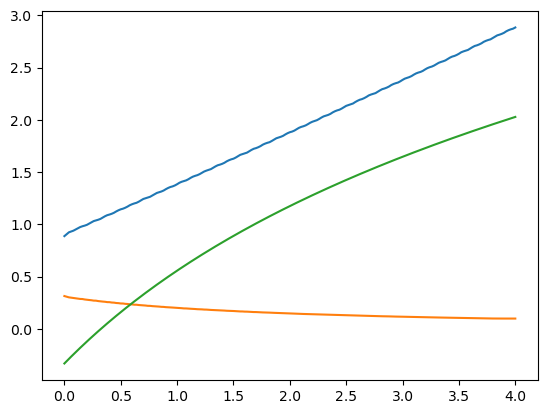

In [3]:
i = 2

plt.plot(a_grid, sol_c_work[i])
plt.plot(a_grid, sol_h_work[i])
plt.plot(a_grid, sol_V_work[i])

In [4]:
N_sim = 100
T_sim = T

mu = -2.0       # mean of log(X)
sigma = 0.5    # std of log(X)

sim_a_init = np.clip(np.random.lognormal(mean=mu, sigma=sigma, size=100), 0, N_a_max)

sim_shape = (T_sim, N_sim)
sim_shape_a = (T_sim+1, N_sim)

a_sim = np.full(sim_shape_a, np.nan)
h_sim = np.full(sim_shape, np.nan)
c_sim = np.full(sim_shape, np.nan)

a_sim[0] = sim_a_init

for t in range(T_sim):
    for i in range(N_sim):
        a = a_sim[t, i]

        sim_V_work = interp_1d(a_grid, sol_V_work[t], a)
        sim_V_notwork = interp_1d(a_grid, sol_V_notwork[t], a)

        if sim_V_work > sim_V_notwork:
            h = interp_1d(a_grid, sol_h_work[t], a)
            c = interp_1d(a_grid, sol_c_work[t], a)
        else:
            h = 0.0
            c = interp_1d(a_grid, sol_c_notwork[t], a)
        
        h_sim[t, i] = h
        c_sim[t, i] = c

        # update assets
        a_next = a + h + B(h, t) - c

        if t < T_sim:
            a_sim[t+1, i] = a_next


In [5]:
share_working = np.nanmean(np.where(h_sim > 0, 1.0, 0.0), axis=1)

hours_if_work = np.nanmean(np.where(h_sim > 0, h_sim, np.nan), axis=1)

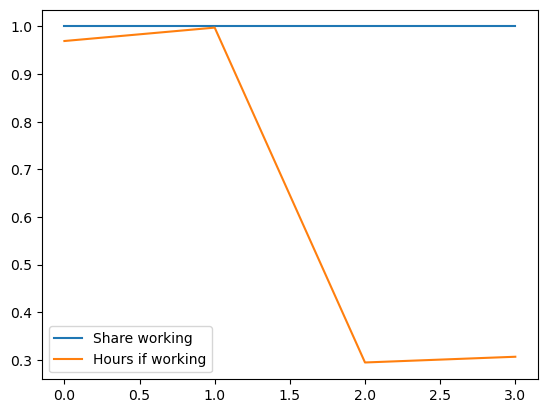

In [6]:
plt.plot(share_working)
plt.plot(hours_if_work)
legend = ["Share working", "Hours if working"]
plt.legend(legend)

In [7]:
hours_if_work

array([0.96949021, 0.99761211, 0.29461884, 0.3066459 ])